# CZĘŚĆ 1. Import i czyszczenie danych 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('/Users/paulinarejda/Desktop/praca_dypl_sgh/train.csv')

In [2]:
# info o ramce, typy zmiennych
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [3]:
# usunięcie zbędnych zmiennych
data = data.drop(['zipcode', 'thumbnail_url', 'first_review', 'last_review'], axis=1)

In [4]:
# zmiana % na numeric
data['host_response_rate'] = pd.to_numeric(data.host_response_rate.str.rstrip("%"))

In [5]:
data.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,host_since,instant_bookable,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,2012-03-26,f,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,2017-06-19,t,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,2016-10-25,t,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,2015-04-19,f,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,2015-03-01,t,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,0.0,1.0


# Eliminacja braków

In [6]:
# spr, czy id jest unikatowe dla każdego obiektu
data.id.duplicated().any()

False

In [7]:
# braki - bathrooms
data.bathrooms.isnull().sum()

200

In [8]:
# braki - beds
data.beds.isnull().sum()

131

In [9]:
# braki - bedrooms
data.bedrooms.isnull().sum()

91

In [10]:
# braki - review_scores_rating
data.review_scores_rating.isnull().sum()

16722

In [11]:
# braki - host_response_rate
data.host_response_rate.isnull().sum()

18299

In [12]:
# spr, ile jest braków w dzielnicach
data.neighbourhood.isnull().sum()

6872

In [13]:
# usunięcie braków w zm. neighbourhood (do grupowania)
data = data.drop(data[data.neighbourhood.isnull()].index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67239 entries, 0 to 74110
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      67239 non-null  int64  
 1   log_price               67239 non-null  float64
 2   property_type           67239 non-null  object 
 3   room_type               67239 non-null  object 
 4   amenities               67239 non-null  object 
 5   accommodates            67239 non-null  int64  
 6   bathrooms               67046 non-null  float64
 7   bed_type                67239 non-null  object 
 8   cancellation_policy     67239 non-null  object 
 9   cleaning_fee            67239 non-null  bool   
 10  city                    67239 non-null  object 
 11  description             67239 non-null  object 
 12  host_has_profile_pic    67054 non-null  object 
 13  host_identity_verified  67054 non-null  object 
 14  host_response_rate      49904 non-null

In [14]:
# grupowanie wg dzielnic
group_nh = data.groupby('neighbourhood')
group_nh

In [15]:
# uzupełnianie braków - BATHROOMS

# obliczanie mediany cen dla każdej z dzielnic
nh_median = group_nh.bathrooms.median()

# tworzenie połączonej tabeli data z medianami wg dzielnic
joined = pd.merge(data, nh_median, on=['neighbourhood'], how='left')

# tworzenie dwóch osobnych tabel - z brakami i bez 
good = joined[joined['bathrooms_x'].notnull()]
bad = joined[joined['bathrooms_x'].isnull()]

# zmiana nazwy kolumn x i usunięcie kolumn y powstałych podczas łączenia (dla obu tabel)
good = good.rename(columns={"bathrooms_x": "bathrooms"})
good = good.drop(['bathrooms_y'], axis=1)

bad = bad.rename(columns={"bathrooms_y": "bathrooms"})
bad = bad.drop(['bathrooms_x'], axis=1)

# dodanie tabel
good = good.append(bad)

data = good

In [16]:
# BEDS

nh_median1 = group_nh.beds.median()

joined1 = pd.merge(data, nh_median1, on=['neighbourhood'], how='left')

good1 = joined1[joined1['beds_x'].notnull()]
bad1 = joined1[joined1['beds_x'].isnull()]

good1 = good1.rename(columns={"beds_x": "beds"})
good1 = good1.drop(['beds_y'], axis=1)

bad1 = bad1.rename(columns={"beds_y": "beds"})
bad1 = bad1.drop(['beds_x'], axis=1)

good1 = good1.append(bad1)

data = good1

In [17]:
# BEDROOMS

nh_median2 = group_nh.bedrooms.median()

joined2 = pd.merge(data, nh_median2, on=['neighbourhood'], how='left')

good2 = joined2[joined2['bedrooms_x'].notnull()]
bad2 = joined2[joined2['bedrooms_x'].isnull()]

good2 = good2.rename(columns={"bedrooms_x": "bedrooms"})
good2 = good2.drop(['bedrooms_y'], axis=1)

bad2 = bad2.rename(columns={"bedrooms_y": "bedrooms"})
bad2 = bad2.drop(['bedrooms_x'], axis=1)

good2 = good2.append(bad2)

data = good2

In [18]:
# review_scores_rating

nh_median3 = group_nh.review_scores_rating.median()

joined3 = pd.merge(data, nh_median3, on=['neighbourhood'], how='left')

good3 = joined3[joined3['review_scores_rating_x'].notnull()]
bad3 = joined3[joined3['review_scores_rating_x'].isnull()]

good3 = good3.rename(columns={"review_scores_rating_x": "review_scores_rating"})
good3 = good3.drop(['review_scores_rating_y'], axis=1)

bad3 = bad3.rename(columns={"review_scores_rating_y": "review_scores_rating"})
bad3 = bad3.drop(['review_scores_rating_x'], axis=1)

good3 = good3.append(bad3)

data = good3

In [19]:
# host_response_rate

nh_median4 = group_nh.host_response_rate.median()

joined4 = pd.merge(data, nh_median4, on=['neighbourhood'], how='left')

good4 = joined4[joined4['host_response_rate_x'].notnull()]
bad4 = joined4[joined4['host_response_rate_x'].isnull()]

good4 = good4.rename(columns={"host_response_rate_x": "host_response_rate"})
good4 = good4.drop(['host_response_rate_y'], axis=1)

bad4 = bad4.rename(columns={"host_response_rate_y": "host_response_rate"})
bad4 = bad4.drop(['host_response_rate_x'], axis=1)

good4 = good4.append(bad4)

data = good4

In [20]:
# nadpisywanie braków medianą
data.bathrooms.fillna(data.bathrooms.median(), inplace=True)
data.beds.fillna(data.beds.median(), inplace=True)
data.bedrooms.fillna(data.bedrooms.median(), inplace=True)
data.review_scores_rating.fillna(data.review_scores_rating.median(), inplace=True)

# usunięcie braków w pozostałych zmiennych
data = data.dropna()
data = data.reset_index()

In [21]:
# spr. jeszcze raz
data.isnull().any()

index                     False
id                        False
log_price                 False
property_type             False
room_type                 False
amenities                 False
accommodates              False
bathrooms                 False
bed_type                  False
cancellation_policy       False
cleaning_fee              False
city                      False
description               False
host_has_profile_pic      False
host_identity_verified    False
host_response_rate        False
host_since                False
instant_bookable          False
latitude                  False
longitude                 False
name                      False
neighbourhood             False
number_of_reviews         False
review_scores_rating      False
bedrooms                  False
beds                      False
dtype: bool

In [22]:
# usunięcie indeksu i id, podsumowanie zmiennych
data = data.drop(['index', 'id'], axis = 1)

In [23]:
# Zmiana wartości tekstowych 't' i 'f' na typ boolean
data = data.replace({'f':False, 't':True})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67035 entries, 0 to 67034
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               67035 non-null  float64
 1   property_type           67035 non-null  object 
 2   room_type               67035 non-null  object 
 3   amenities               67035 non-null  object 
 4   accommodates            67035 non-null  int64  
 5   bathrooms               67035 non-null  float64
 6   bed_type                67035 non-null  object 
 7   cancellation_policy     67035 non-null  object 
 8   cleaning_fee            67035 non-null  bool   
 9   city                    67035 non-null  object 
 10  description             67035 non-null  object 
 11  host_has_profile_pic    67035 non-null  bool   
 12  host_identity_verified  67035 non-null  bool   
 13  host_response_rate      67035 non-null  float64
 14  host_since              67035 non-null

In [24]:
# zmiana formatu daty i obliczenie stażu gospodarzy (w latach)
from datetime import datetime
from datetime import date

data['host_since']= pd.to_datetime(data['host_since']) 
data['data_zb'] = pd.to_datetime('2018-02-09')
data['host_days'] = data.data_zb - data.host_since
data['host_years'] = (data['host_days'] / np.timedelta64(1, 'Y')).round()

In [25]:
# usunięcie zbędnych kolumn
data = data.drop(['host_since', 'host_days', 'data_zb'], axis=1)
data.head()

,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,...,instant_bookable,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,bedrooms,beds,host_years
0,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,...,True,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,3.0,3.0,1.0
1,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,...,True,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,1.0,3.0,1.0
2,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,...,True,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,0.0,1.0,3.0
3,4.442651,Apartment,Private room,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,Real Bed,strict,True,SF,...,True,37.753164,-122.429526,Comfort Suite San Francisco,Noe Valley,3,100.0,1.0,1.0,1.0
4,4.787492,Condominium,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Wheelchair...",2,1.0,Real Bed,moderate,True,LA,...,False,34.046737,-118.260439,"Near LA Live, Staple's. Starbucks inside. OWN ...",Downtown,9,93.0,1.0,1.0,5.0


In [26]:
# definiowanie zmiennych nominalnych
data['property_type'] = data['property_type'].astype('category')
data['bed_type'] = data['bed_type'].astype('category')
data['city'] = data['city'].astype('category')
data['cleaning_fee'] = data['cleaning_fee'].astype('category')
data['host_has_profile_pic'] = data['host_has_profile_pic'].astype('category')
data['host_identity_verified'] = data['host_identity_verified'].astype('category')
data['instant_bookable'] = data['instant_bookable'].astype('category')


In [27]:
# definiowanie zmiennych porządkowych - cancellation policy
from pandas.api.types import CategoricalDtype

data.groupby('cancellation_policy').mean()
    # utworzenie zmiennej typu category o charakterze porządkowym
canpol = CategoricalDtype(categories=['super_strict_60', 'super_strict_30', 'strict', 
                                      'moderate','flexible'], ordered=True)
data['cancellation_policy'] = data['cancellation_policy'].astype(canpol)

# definiowanie zmiennych porządkowych - room_type
data.groupby('room_type').mean()
roomt = CategoricalDtype(categories=['Shared room', 'Private room', 'Entire home/apt'],
                         ordered=True)
data['room_type'] = data['room_type'].astype(roomt)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67035 entries, 0 to 67034
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   log_price               67035 non-null  float64 
 1   property_type           67035 non-null  category
 2   room_type               67035 non-null  category
 3   amenities               67035 non-null  object  
 4   accommodates            67035 non-null  int64   
 5   bathrooms               67035 non-null  float64 
 6   bed_type                67035 non-null  category
 7   cancellation_policy     67035 non-null  category
 8   cleaning_fee            67035 non-null  category
 9   city                    67035 non-null  category
 10  description             67035 non-null  object  
 11  host_has_profile_pic    67035 non-null  category
 12  host_identity_verified  67035 non-null  category
 13  host_response_rate      67035 non-null  float64 
 14  instant_bookable      

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67035 entries, 0 to 67034
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   log_price               67035 non-null  float64 
 1   property_type           67035 non-null  category
 2   room_type               67035 non-null  category
 3   amenities               67035 non-null  object  
 4   accommodates            67035 non-null  int64   
 5   bathrooms               67035 non-null  float64 
 6   bed_type                67035 non-null  category
 7   cancellation_policy     67035 non-null  category
 8   cleaning_fee            67035 non-null  category
 9   city                    67035 non-null  category
 10  description             67035 non-null  object  
 11  host_has_profile_pic    67035 non-null  category
 12  host_identity_verified  67035 non-null  category
 13  host_response_rate      67035 non-null  float64 
 14  instant_bookable      

# CZĘŚĆ 2. Analizy

In [29]:
#import matplotlib.pyplot as plt

In [30]:
# tabela bez współrzędnych geogr.
data1 = data.drop(['latitude', 'longitude'], axis=1)

In [31]:
# podstawowe statystyki 
stat = data1.describe().round(2)
stat

,log_price,accommodates,bathrooms,host_response_rate,number_of_reviews,review_scores_rating,bedrooms,beds,host_years
count,67035.00,67035.00,67035.00,67035.00,67035.00,67035.00,67035.00,67035.00,67035.00
mean,4.80,3.14,1.23,95.89,21.47,94.51,1.26,1.70,3.63
std,0.71,2.12,0.57,14.03,38.61,6.89,0.85,1.24,1.85
min,0.00,1.00,0.00,0.00,0.00,20.00,0.00,0.00,0.00
25%,4.32,2.00,1.00,100.00,1.00,93.00,1.00,1.00,2.00
50%,4.74,2.00,1.00,100.00,6.00,96.00,1.00,1.00,3.00
75%,5.24,4.00,1.00,100.00,24.00,99.00,1.00,2.00,5.00
max,7.60,16.00,8.00,100.00,542.00,100.00,10.00,18.00,10.00


In [32]:
# macierz korelacji
corr1 = data1.corr().round(2)
corr1

,log_price,accommodates,bathrooms,host_response_rate,number_of_reviews,review_scores_rating,bedrooms,beds,host_years
log_price,1.00,0.57,0.35,-0.00,-0.04,0.09,0.47,0.44,0.06
accommodates,0.57,1.00,0.49,0.02,0.04,-0.02,0.71,0.81,-0.01
bathrooms,0.35,0.49,1.00,-0.00,-0.04,0.02,0.57,0.51,-0.00
host_response_rate,-0.00,0.02,-0.00,1.00,0.07,0.05,0.01,0.02,0.01
number_of_reviews,-0.04,0.04,-0.04,0.07,1.00,-0.02,-0.03,0.03,0.20
review_scores_rating,0.09,-0.02,0.02,0.05,-0.02,1.00,0.02,-0.03,0.03
bedrooms,0.47,0.71,0.57,0.01,-0.03,0.02,1.00,0.70,0.01
beds,0.44,0.81,0.51,0.02,0.03,-0.03,0.70,1.00,-0.03
host_years,0.06,-0.01,-0.00,0.01,0.20,0.03,0.01,-0.03,1.00


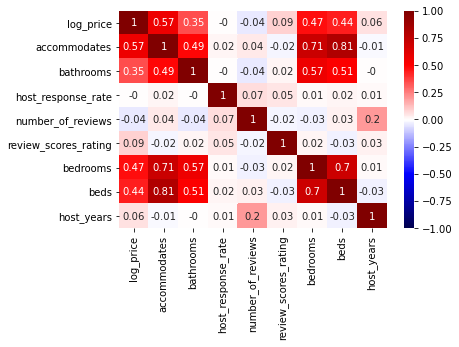

In [33]:
# graficzna reprezentacja macierzy korelacji
sns.heatmap(corr1, cmap = 'seismic', vmin = -1, vmax = 1, annot = True)

In [34]:
# paleta
'#000000', '#14213d', '#fca311', '#e5e5e5', '#ffffff'

('#000000', '#14213d', '#fca311', '#e5e5e5', '#ffffff')

Text(0.5, 1.0, 'host_response_rate')

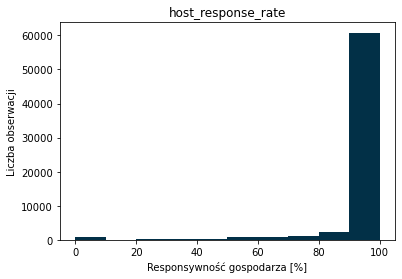

In [35]:
# histogram - responsywność gospodarza
plt.hist(data.host_response_rate, color='#023047')
plt.xlabel('Responsywność gospodarza [%]')
plt.ylabel('Liczba obserwacji')
plt.title('host_response_rate')

Text(0.5, 1.0, 'number_of_reviews')

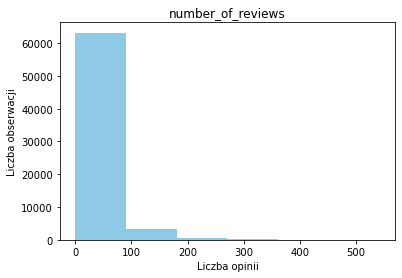

In [36]:
# histogram - liczba opinii
plt.hist(data.number_of_reviews, color='#8ecae6', bins=6)
plt.xlabel('Liczba opinii')
plt.ylabel('Liczba obserwacji')
plt.title('number_of_reviews')

Text(0.5, 1.0, 'review_scores_rating')

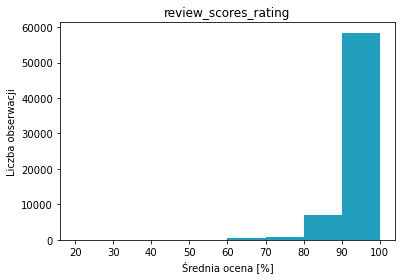

In [37]:
# histogram - średnia ocena
plt.hist(data.review_scores_rating, color='#219ebc', bins=8)
plt.xlabel('Średnia ocena [%]')
plt.ylabel('Liczba obserwacji')
plt.title('review_scores_rating')

Text(0.5, 1.0, 'Doświadczenie gospodarzy')

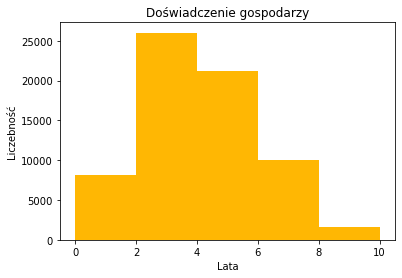

In [38]:
# histogram - staż gospodarzy
plt.hist(data.host_years, bins=5, color='#ffb703')
plt.xlabel('Lata')
plt.ylabel('Liczebność')
plt.title('Doświadczenie gospodarzy')

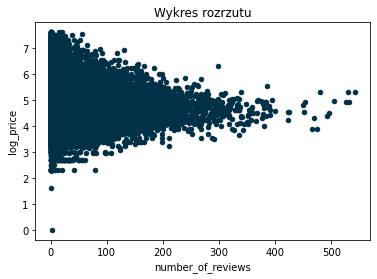

In [39]:
# wykres rozrzutu dla ceny w zależności od liczby opinii
data.plot.scatter('number_of_reviews', 'log_price', title='Wykres rozrzutu', color='#023047')

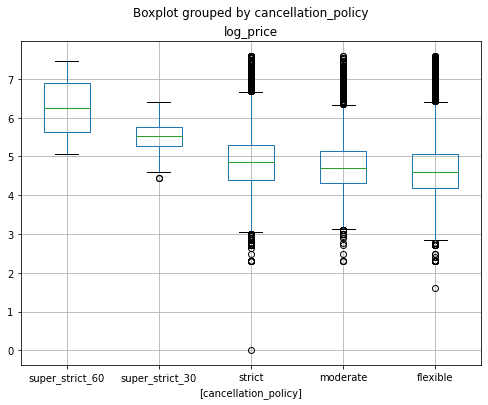

In [40]:
# boxploty dla cen w zależności od polityki anulacyjnej
data[['log_price', 'cancellation_policy']].boxplot(by = 'cancellation_policy', figsize=(8,6))

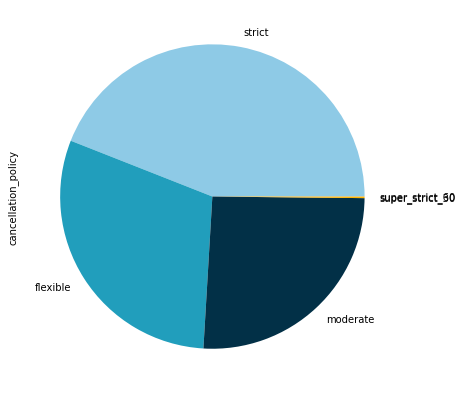

In [41]:
# wykres kołowy - liczebności - polityka anulacyjna
data.cancellation_policy.value_counts().plot.pie(colors = ["#8ecae6","#219ebc","#023047","#ffb703","#fb8500"], figsize=(7,7))

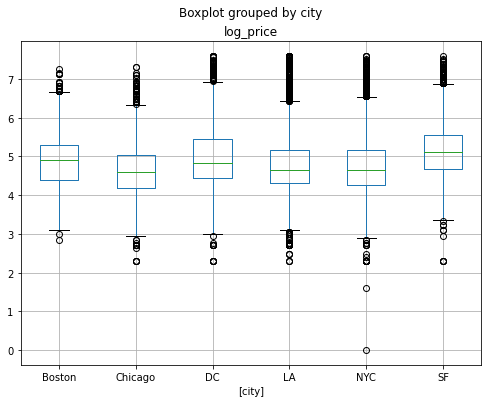

In [42]:
# boxploty dla cen wg miast
data[['log_price','city']].boxplot(by='city', figsize=(8,6))

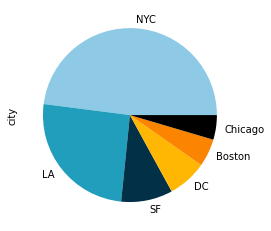

In [43]:
# wykres kołowy - liczebności - miasta
data.city.value_counts().plot.pie(colors = ["#8ecae6","#219ebc","#023047","#ffb703","#fb8500", "black"])

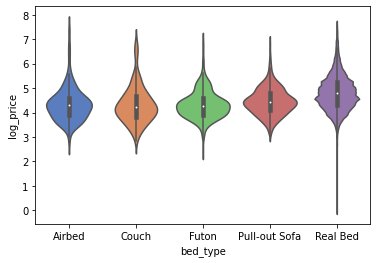

In [44]:
# wykresy wiolinowe dla cen w zależności od rodzaju łóżka
sns.violinplot(x = 'bed_type', y = 'log_price', data = data, palette = 'muted')

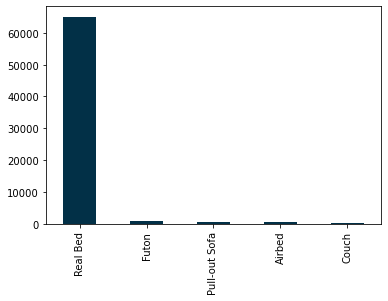

In [45]:
# wykres słupkowy - liczebności - rodzaj łóżka
data.bed_type.value_counts().plot.bar(color='#023047')

In [46]:
# liczba obiektów należących do kategorii
print('super_strict_60:', data.cancellation_policy[data.cancellation_policy == 'super_strict_60'].count())
print('super_strict_60:', data.cancellation_policy[data.cancellation_policy == 'super_strict_30'].count())
print('strict:', data.cancellation_policy[data.cancellation_policy == 'strict'].count())
print('moderate:', data.cancellation_policy[data.cancellation_policy == 'moderate'].count())
print('flexible:', data.cancellation_policy[data.cancellation_policy == 'flexible'].count())

super_strict_60: 10
super_strict_60: 102
strict: 29513
moderate: 17275
flexible: 20135


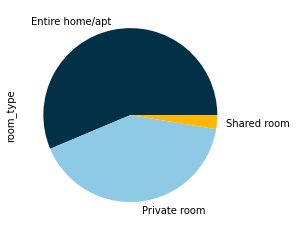

In [47]:
# wykres kołowy - liczebności - rodzaj pokoju (prywatność)
data.room_type.value_counts().plot.pie(colors = ["#023047", "#8ecae6","#ffb703"])

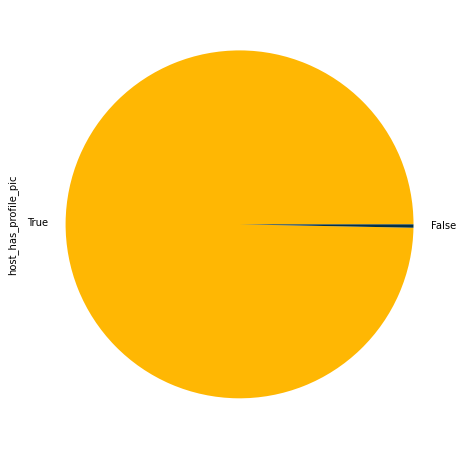

In [48]:
# wykres kołowy - liczebności - posiadanie zdj. profilowego przez gospodarza
data['host_has_profile_pic'].value_counts().plot.pie(colors = ['#ffb703', '#023047'],figsize=(8,8))

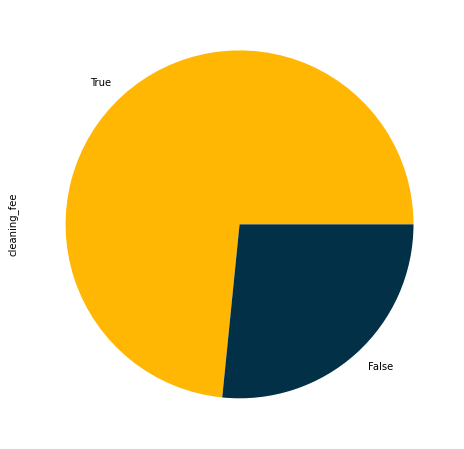

In [49]:
# wykres kołowy - liczebności - opłata za sprzątanie
data['cleaning_fee'].value_counts().plot.pie(colors = ['#ffb703', '#023047'],figsize=(8,8))

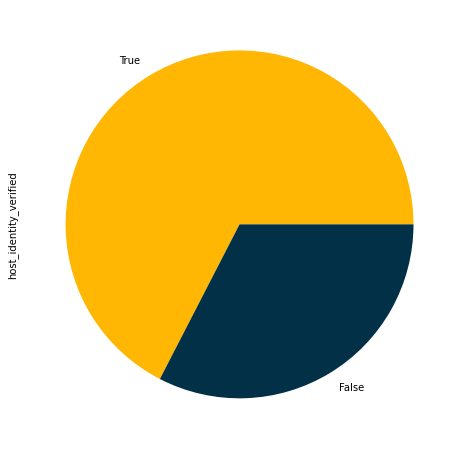

In [50]:
# wykres kołowy - liczebności - posiadanie potwierdzonej tożsamości przez gospodarza
data['host_identity_verified'].value_counts().plot.pie(colors = ['#ffb703', '#023047'],figsize=(8,8))

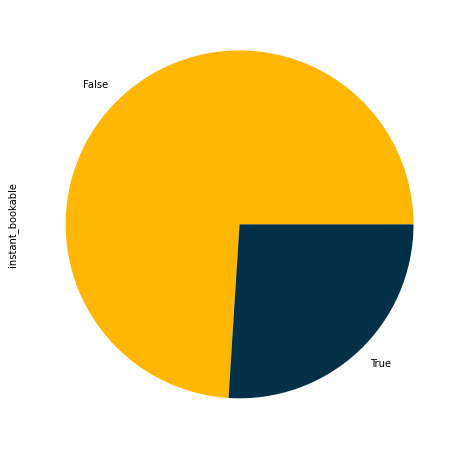

In [51]:
# wykres kołowy - liczebności - automatyczne potwierdzenie rezerwacji
data['instant_bookable'].value_counts().plot.pie(colors = ['#ffb703', '#023047'],figsize=(8,8))

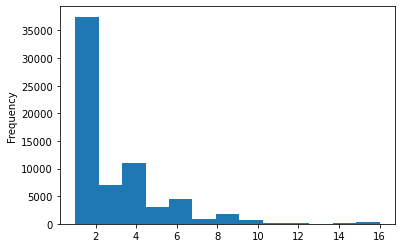

In [52]:
# histogram - max liczba lokatorów
data['accommodates'].plot.hist(bins=13)

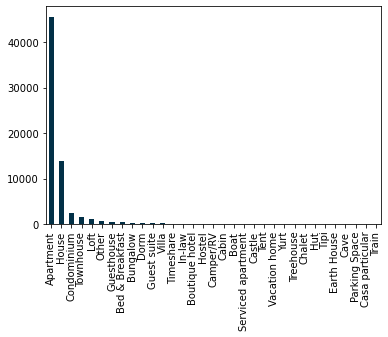

In [53]:
# wykres słupkowy - rodzaj obiektu
data.property_type.value_counts().plot.bar(color='#023047')

In [54]:
# typy obiektów (liczba dostępnych typów - dlugość wektora)
data.property_type.unique()

['Apartment', 'Condominium', 'House', 'Townhouse', 'Loft', ..., 'Earth House', 'Train', 'Cave', 'Casa particular', 'Parking Space']
Length: 33
Categories (33, object): ['Apartment', 'Condominium', 'House', 'Townhouse', ..., 'Train', 'Cave', 'Casa particular', 'Parking Space']

In [55]:
#data.bathrooms.value_counts().plot.bar(color = ['yellow', 'red', 'pink', 'green', 'purple', 'silver'])

In [56]:
#model - cena ~ l. łazienek, oc. responsywności gosp., średnia ocena obiektu
import statsmodels.api as sm
model1 = sm.OLS(endog=data['log_price'],
            exog=data[['bedrooms', 'host_response_rate', 'review_scores_rating']]).fit()
model1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              log_price   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          1.163e+06
Date:                Wed, 03 Mar 2021   Prob (F-statistic):                        0.00
Time:                        01:42:09   Log-Likelihood:                         -67872.
No. Observations:               67035   AIC:                                  1.358e+05
Df Residuals:                   67032   BIC:                                  1.358e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
bedrooms                 0.4164      0.003    137.510      0.000       0.410       0.422
host_response_rate       0.0063      0.000     37.805      0.000       0.006       0.007
review_scores_rating     0.0386      0.000    221.700      0.000       0.038       0.039
==============================================================================
Omnibus:                     3405.853   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5790.589
Skew:                           0.417   Prob(JB):                         0.00
Kurtosis:                       4.174   Cond. No.                         159.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
# wizualizacja danych na mapie

#import folium
#from math import floor

#map = folium.Map()

#for apt in data.iterrows():
 #   lat = data.latitude
 #   lon = data.longitude
 #   name = data.neighbourhood
 #   price = data.log_price
 #   folium.Marker([lat, lon],
 #                popup=name+"<br />"+str(price)).add_to(map)
    
#map

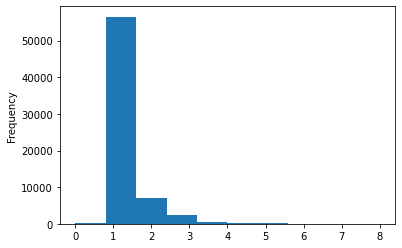

In [59]:
# histogram dla zmiennej bathrooms
data['bathrooms'].plot.hist()

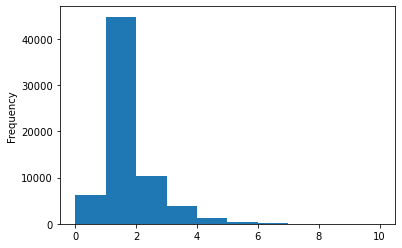

In [60]:
# histogram dla zmiennej bedrooms
data['bedrooms'].plot.hist()

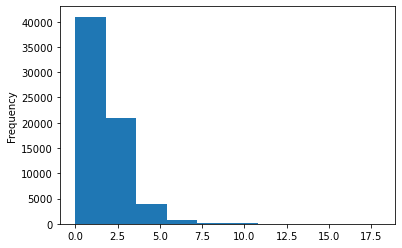

In [61]:
# histogram dla zmiennej beds
data['beds'].plot.hist()

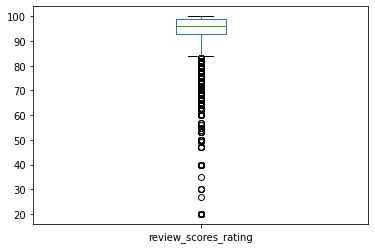

In [62]:
# wykres pudełkowy dla zmienej review_scores_rating
data.review_scores_rating.plot.box()